# ML for Bioinformatics (30 points)
## HW5 - Long short-term memory

---

Name: AmirHossein Mohammadi

Student No.: 99201081

---


# ECG Heartbeat Classification

In this exercise we aim to perform a classification task on a bunch of ECG recorded signals. To this end, you will implement two models with different architectures: 1- LSTM neural network 2- Convolutional neural network. You are supposed to achieve a high performance on both models.

Attention: In this notebook you are only allowed to change the sections denoted by the following mark:

    # ========================= Place Your Code Here ========================= #

    # ======================================================================== #



# Collect Data
We use a preprocessed version of a famous datasets in heartbeat classification, [the MIT-BIH Arrhythmia Dataset](https://physionet.org/content/mitdb/1.0.0/). 
The signals in this dataset correspond to electrocardiogram (ECG) shapes of heartbeats for the normal case and the cases affected by different arrhythmias and myocardial infarction. We will use the Arrhythmia Dataset used in [this paper](https://arxiv.org/abs/1805.00794) which is the preprocessed arrhythmia dataset consisting of signals that are preprocessed and segmented, with each segment corresponding to a heartbeat in the dataset. This dataset is composed of 109446 samples which are classified into 5 categories.

You must download the dataset from [here](https://drive.google.com/file/d/1BhedBaKpVPT_QJgGFPIc-UiCj_PhoOwo/view?usp=sharing). It is also accessible on [kaggle](https://www.kaggle.com/shayanfazeli/heartbeat).
The training and test data are located in mitbih_train.csv and mitbih_test.csv files. Locate these files in dataset folder next to this notebook. If you are running this notebook on colab (which is strongly recommended), you should first copy the dataset into your Google drive and the then running the code bellow will do the rest.

In [ ]:
FOLDERNAME = 'HW05-1'   #تغییر#

In [ ]:
assert FOLDERNAME is not None, 'HW05-1'

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

%cp -r /content/drive/MyDrive/$FOLDERNAME /content/
!unzip /content/$FOLDERNAME/29414_37484_bundle_archive.zip



Mounted at /content/drive
Archive:  /content/HW05-1/29414_37484_bundle_archive.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm, trange
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from IPython import display
import torch.backends.cudnn as cudnn
import random

def set_seed(seed):
    cudnn.deterministic = True
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


# Read The Dataset (3 points)
This dataset consists of a series of CSV files. Each of these CSV files contain a matrix, with each row representing an example in that portion of the dataset. The final element of each row denotes the class to which that example belongs. In this section you are asked to load the samples from "mitbih_train.csv" and "mitbih_test.csv" files into seperate numpy arrays. 

hint: you can use pandas.read_csv function for reading csv files.

In [ ]:
# ========================= Place Your Code Here ========================= #
#تغییر# 
dataframe_train = pd.read_csv("mitbih_train.csv",skiprows=[0])
dataframe_train
dataframe_test = pd.read_csv("mitbih_test.csv", header=None)

#data_train = np.array(dataframe_train.drop(columns=187)).astype('float32')
#labels_train = np.array(dataframe_train[187]).astype('int64')

#data_test = np.array(dataframe_test.drop(columns=187)).astype('float32')
#labels_test = np.array(dataframe_test[187]).astype('int64')

# ======================================================================== #

In [ ]:
dataframe_train

,9.601139426231384277e-01,8.632478713989257812e-01,4.615384638309478760e-01,1.965811997652053833e-01,9.401709586381912231e-02,1.253561228513717651e-01,9.971509873867034912e-02,8.831908553838729858e-02,7.407407462596893311e-02,8.262108266353607178e-02,7.407407462596893311e-02.1,6.267806142568588257e-02,6.552706658840179443e-02,6.552706658840179443e-02.1,6.267806142568588257e-02.1,7.692307978868484497e-02,7.122506946325302124e-02,8.262108266353607178e-02.1,9.116809070110321045e-02,9.686609357595443726e-02,8.262108266353607178e-02.2,8.262108266353607178e-02.3,9.116809070110321045e-02.1,1.054131090641021729e-01,1.225071251392364502e-01,1.481481492519378662e-01,1.823361814022064209e-01,1.937321871519088745e-01,2.136752158403396606e-01,2.079772055149078369e-01,2.222222238779067993e-01,2.535612583160400391e-01,2.706552743911743164e-01,2.877492904663085938e-01,2.849002778530120850e-01,2.934472858905792236e-01,2.564102709293365479e-01,2.478632479906082153e-01,1.880341917276382446e-01,1.452991515398025513e-01,...,0.000000000000000000e+00.13,0.000000000000000000e+00.14,0.000000000000000000e+00.15,0.000000000000000000e+00.16,0.000000000000000000e+00.17,0.000000000000000000e+00.18,0.000000000000000000e+00.19,0.000000000000000000e+00.20,0.000000000000000000e+00.21,0.000000000000000000e+00.22,0.000000000000000000e+00.23,0.000000000000000000e+00.24,0.000000000000000000e+00.25,0.000000000000000000e+00.26,0.000000000000000000e+00.27,0.000000000000000000e+00.28,0.000000000000000000e+00.29,0.000000000000000000e+00.30,0.000000000000000000e+00.31,0.000000000000000000e+00.32,0.000000000000000000e+00.33,0.000000000000000000e+00.34,0.000000000000000000e+00.35,0.000000000000000000e+00.36,0.000000000000000000e+00.37,0.000000000000000000e+00.38,0.000000000000000000e+00.39,0.000000000000000000e+00.40,0.000000000000000000e+00.41,0.000000000000000000e+00.42,0.000000000000000000e+00.43,0.000000000000000000e+00.44,0.000000000000000000e+00.45,0.000000000000000000e+00.46,0.000000000000000000e+00.47,0.000000000000000000e+00.48,0.000000000000000000e+00.49,0.000000000000000000e+00.50,0.000000000000000000e+00.51,0.000000000000000000e+00.52
0,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,0.328152,0.417962,0.426598,0.442142,0.433506,0.435233,0.449050,0.435233,0.402418,0.404145,0.405872,0.390328,0.369603,0.373057,0.367876,0.348877,0.317789,0.316062,0.319516,0.322971,0.324698,0.

Let's check your code. You may be able to pass the following tests if the data is loaded correctly.

In [ ]:

assert data_train.shape == (87554, 187)
assert labels_train.shape == (87554,)
assert len (labels_train[labels_train == 4]) == 6431
assert data_test.shape == (21892, 187)
assert labels_test.shape == (21892,)

assert data_train.dtype == np.float32
assert labels_train.dtype == np.int64
assert data_test.dtype  == np.float32
assert labels_test.dtype  == np.int64
print ("Test passed")

Test passed


Now let's see an example of the signals in the dataset. By running the code bellow you should be able to see a graph containing two plots with labels 1 and 4.

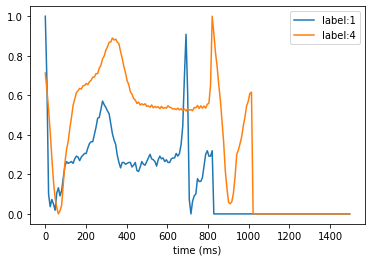

In [ ]:
t = np.linspace (0,(187/125)*1000, 187)
plt.plot (t,data_train[labels_train == 1][0] , label = f"label:{labels_train[labels_train == 1][0]}")
plt.plot (t,data_train[labels_train == 4][0] , label = f"label:{labels_train[labels_train == 4][0]}")
plt.legend()
plt.xlabel("time (ms)")
plt.show()

# Create Custom Dataset (3 points)
You need to create your custom dataset so you can define a dataloader to use in the train and test phase. Your class must implement init, getitem and len methods.

In [ ]:
class HeartbeatDataset(Dataset):
  #تغییر#
    
    def __init__(self, data, labels):
        # ========================= Place Your Code Here ========================= #
        self.LB = labels
        self.Train_LB = data
        # ======================================================================== #
        
    def __getitem__(self, index):
        # ========================= Place Your Code Here ========================= #
        t,l=self.Train_LB[index], self.LB[index]
        return t,l
        # ======================================================================== #        
         
    def __len__(self):
        # ========================= Place Your Code Here ========================= #
        return len(self.Train_LB)
        # ======================================================================== #                


batch_size = 64

train_set = HeartbeatDataset(data_train, labels_train)
train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)

test_set = HeartbeatDataset(data_test, labels_test)
test_loader = DataLoader(dataset=test_set,
                        batch_size=batch_size,
                         shuffle=True)



Make sure that the following test passes.

In [ ]:
assert len (train_set) == 87554
assert len (test_set) == 21892
(batch_data, batch_label) = next (iter (train_loader))
assert batch_data.shape == (batch_size, 187)
assert batch_label.shape == (batch_size,)
print ("passed")

passed


In this part we will find the number of samples in each class. We are going to need this in next sections.

In [ ]:
num_classes = 5
class_samples_num = [0 for i in range(num_classes)]
for data in train_loader:
    inputs, labels = data        
    for i in labels:
        class_samples_num[i] += 1

print(class_samples_num)

[72471, 2223, 5788, 641, 6431]


# Create LSTM Classifier (8 points)
Now you are ready to implement your LSTM neural network which inherits from nn.Module. The structure of the network must be as follows:

  (lstm): LSTM(1, 64, batch_first=True)<br>
  (fc1): Linear(in_features=64, out_features=32, bias=True)<br>
  (relu): ReLU()<br>
  (fc2): Linear(in_features=32, out_features=5, bias=True)<br>

At each step the value of signal is given as input to the LSTM block. The hidden state and cell state get updated. Finally the output is computed by two fully connected on top of hidden states with a softmax layer at the end.

Attention: Be carefull about tensor shapes, Dont forget to unsqueeze the input.

In [ ]:
class LSTMClassifier(nn.Module):

    def __init__(self):
        super(LSTMClassifier, self).__init__() 
        # ========================= Place Your Code Here ========================= #
        self.LSTM_RNN = nn.LSTM(1, 64, batch_first=True)
        self.fully_connected_1= nn.Linear(in_features=64, out_features=32, bias=True)
        self.Activation_function = nn.ReLU()
        self.fully_connected_2= nn.Linear(in_features=32, out_features=5, bias=True)
        self.SoftMax=nn.Softmax()
        # ======================================================================== #   

    def forward(self, x):
        # ========================= Place Your Code Here ========================= #
        temp=torch.unsqueeze(x,-1)
        temp = self.LSTM_RNN(temp)[1][0][-1]
        temp = self.Activation_function(self.fully_connected_1(temp))
        output = self.fully_connected_2(temp)
        return self.SoftMax(output)
        # ======================================================================== #   


In [ ]:
(batch_data, batch_label) = next (iter (train_loader))
model = LSTMClassifier().to(device)
output = model (batch_data.to(device)).cpu()
assert output.shape == (batch_size, 5)
print ("passed")

passed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Now let's check if your output shape is correct:

# Define loss function and optimizer (2 points)
Next you can instance a classifier, loss function and optimizer. Because of the imbalanced dataset, the model may tend to label the whole test data as "normal". So we must make the model pay more attention to the minor cases. There are different ways to do so. One of them is the upsampling technique in which we produce enough samples for all categories, by resampling from the present data. Another way is to weight loss of each sample proportional to inverse of its caregory's number of samples. So weights of samples of each category sum to one, and the model pays equal attention to all categories. We are going to use this technique by providing the CrossEntropyLoss loss function an array of weights (You can also use other techniques like upsampling). Make sure to visit the [PyTorch page](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) on cross entropy loss. 

In [ ]:
lstm_classifier = LSTMClassifier()
lstm_classifier.to(device)

def get_loss_weights(class_samples_num):
    # ========================= Place Your Code Here ========================= #
    temp=[]
    for i in range(len(class_samples_num)):
      temp.append(1/(class_samples_num[i]))
    loss_weight = torch.tensor(temp)
    loss_weight = loss_weight.type(torch.FloatTensor)   
    return loss_weight
    # ======================================================================== #   
criterion = nn.CrossEntropyLoss(weight=get_loss_weights(class_samples_num))
criterion.to(device)
optimizer = torch.optim.Adam(lstm_classifier.parameters() , lr=1e-3)

In [ ]:
data , label = next(iter(train_loader))
output = lstm_classifier(data.to(device))

assert output.shape == (batch_size, 5) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


# Train the classifier
The following code runs the training phase using what you have build so far. It also feeds the test data to the model at each epoch without updating the weights, so we can study the loss on both training and test data during the training phase by plotting its diagram at the end. You are free to change the number of epochs to acheive the best soloution.

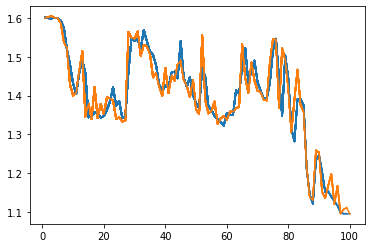

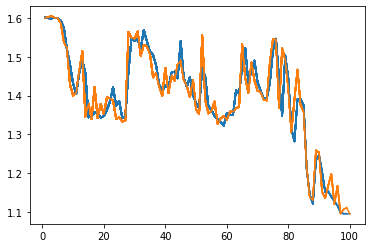

In [ ]:
# ========================= Place Your Code Here ========================= #
epoch_num =100
# ======================================================================== #   
train_log = []
test_log = []
set_seed(111)
for epoch in range(1, epoch_num+1):
    
    running_loss = 0    
    train_loss = []
    lstm_classifier.train()
    for (inputs, labels) in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):        
        inputs, labels = inputs.to(device), labels.to(device)        
        optimizer.zero_grad()
        outputs = lstm_classifier(inputs)
        loss = criterion(outputs, labels)        
        loss.backward()                
        optimizer.step()        
        train_loss.append(loss.item())
    train_log.append(np.mean(train_loss))

    running_loss = 0
    test_loss = []
    lstm_classifier.eval()
    with torch.no_grad():                
        for (inputs, labels) in tqdm(test_loader, desc='Test', leave=False):         
            inputs, labels = inputs.to(device), labels.to(device)        
            outputs = lstm_classifier(inputs)                       
            loss = criterion(outputs, labels)            
            test_loss.append(loss.item())
    test_log.append(np.mean(test_loss))    
    plt.plot(range(1, epoch+1), train_log, color='C0')
    plt.plot(range(1, epoch+1), test_log, color='C1')
    display.clear_output(wait=True)
    display.display(plt.gcf())

# Test the classifier
The following code runs the LSTM classifier on test data and reports the [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html). It also reports the [ROC AUC score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) which shows us how much we have succeeded in handling the imbalanced data. The ROC AUC score is the evaluation criterion of your model. ROC AUC score and accuracy of more than 0.9 are achievable by the model. You are supposed to achieve ROC AUC score and accuracy of at least 0.8.

In [ ]:
y_true = []
y_pred = []
with torch.no_grad():
    lstm_classifier.eval()
    for (inputs, labels) in tqdm(test_loader, desc='Test'):         
        inputs, labels = inputs.to(device), labels.to(device)        
        outputs = lstm_classifier(inputs)                       
        y_true += torch.eye(num_classes)[labels].tolist()
        y_pred += outputs.tolist()
y_true = np.array(y_true)
y_pred = np.array(y_pred)
print('ROC_AUC Score:', roc_auc_score(y_true, y_pred))
print(classification_report(y_true.argmax(axis=1), y_pred.argmax(axis=1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



ROC_AUC Score: 0.9176364114189477
              precision    recall  f1-score   support

           0       0.98      0.77      0.86     18118
           1       0.21      0.59      0.31       556
           2       0.49      0.90      0.64      1448
           3       0.11      0.87      0.20       162
           4       0.66      0.91      0.77      1608

    accuracy                           0.79     21892
   macro avg       0.49      0.81      0.56     21892
weighted avg       0.90      0.79      0.82     21892



# Create Convolutional Classifier (8 points)
Next we are going to assemble a convolution neural netwok. Use the following blocks: <br>
  (conv1): Conv1d(cin = 1, cout = 64, kernel size = 19)<br>
  (fc1): Linear(in_features=64*187, out_features=32, bias=True)<br>
  (relu): ReLU()<br>
  (fc2): Linear(in_features=32, out_features=5, bias=True)<br>

  Again in the same way fill the placeholders and train the conv model.


In [ ]:
class ConvClassifier(nn.Module):

    def __init__(self):
        super(ConvClassifier, self).__init__()
        # ========================= Place Your Code Here ========================= #
        self.Convolution_1 = nn.Conv1d(1,64, kernel_size=19,padding=9)
        self.Fully_Con_1 = nn.Linear(64*187,32, bias=True)
        self.Activ_funct=nn.ReLU(inplace=True)
        self.Fully_Con_2 = nn.Linear(32,5, bias=True)
        self.Soft_max=nn.Softmax()
        # ======================================================================== #   

    def forward(self, x):
        # ========================= Place Your Code Here ========================= #
        temp = x.unsqueeze(1)
        temp = self.Convolution_1(temp)
        temp = self.Fully_Con_1(temp.reshape(temp.shape[0],(temp.shape[1]*temp.shape[2])))
        temp = self.Activ_funct(temp)
        return self.Soft_max(self.Fully_Con_2(temp))
        # ======================================================================== #           


In [ ]:
conv_classifier = ConvClassifier()
conv_classifier.to(device)

criterion = nn.CrossEntropyLoss(weight = get_loss_weights(class_samples_num))
criterion.to(device)
optimizer = torch.optim.Adam(conv_classifier.parameters())


In [ ]:
data , label = next(iter(train_loader))
output = conv_classifier(data.to(device))

assert output.shape == (batch_size, 5) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


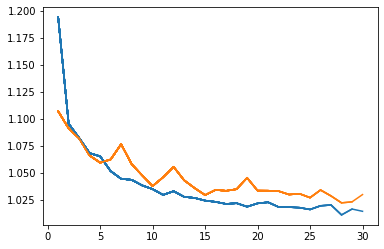

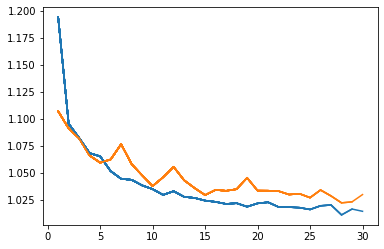

In [ ]:
# ========================= Place Your Code Here ========================= #
epoch_num = 30
# ======================================================================== #   

train_log = []
test_log = []
set_seed(111)
for epoch in range(1, epoch_num+1):
    
    running_loss = 0    
    train_loss = []
    conv_classifier.train()
    for (inputs, labels) in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):        
        inputs, labels = inputs.to(device), labels.to(device)        
        optimizer.zero_grad()
        outputs = conv_classifier(inputs)          
        loss = criterion(outputs, labels)        
        loss.backward()                
        optimizer.step()        
        train_loss.append(loss.item())
    train_log.append(np.mean(train_loss))

    running_loss = 0
    test_loss = []
    conv_classifier.eval()
    with torch.no_grad():                
        for (inputs, labels) in tqdm(test_loader, desc='Test', leave=False):         
            inputs, labels = inputs.to(device), labels.to(device)        
            outputs = conv_classifier(inputs)                       
            loss = criterion(outputs, labels)            
            test_loss.append(loss.item())
    test_log.append(np.mean(test_loss))    
    plt.plot(range(1, epoch+1), train_log, color='C0')
    plt.plot(range(1, epoch+1), test_log, color='C1')
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [ ]:
y_true = []
y_pred = []
with torch.no_grad():
    conv_classifier.eval()
    for (inputs, labels) in tqdm(test_loader, desc='Test'):         
        inputs, labels = inputs.to(device), labels.to(device)        
        outputs = conv_classifier(inputs)                       
        y_true += torch.eye(num_classes)[labels].tolist()
        y_pred += outputs.tolist()
y_true = np.array(y_true)
y_pred = np.array(y_pred)
print('ROC_AUC Score:', roc_auc_score(y_true, y_pred))
print(classification_report(y_true.argmax(axis=1), y_pred.argmax(axis=1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



ROC_AUC Score: 0.9425292991576285
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     18118
           1       0.26      0.77      0.39       556
           2       0.84      0.87      0.86      1448
           3       0.16      0.88      0.27       162
           4       0.83      0.97      0.89      1608

    accuracy                           0.87     21892
   macro avg       0.62      0.87      0.67     21892
weighted avg       0.94      0.87      0.90     21892



# Comparing The Models (6 points)

In [ ]:
def count_parameters(model): 
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

Let's first compare the number of parameters:

In [ ]:
print ("Parameters for lstm classifier=" , count_parameters(lstm_classifier))

Parameters for lstm classifier= 19397


In [ ]:
print ("Parameters for conv classifier=" , count_parameters(conv_classifier))

Parameters for conv classifier= 384453


# Useful Links and Acknowledgements

[An Effective LSTM Recurrent Network to Detect Arrhythmia on Imbalanced ECG Dataset](https://www.hindawi.com/journals/jhe/2019/6320651/)

[Classify ECG Signals Using Long Short-Term Memory Networks
](https://https://www.mathworks.com/help/signal/examples/classify-ecg-signals-using-long-short-term-memory-networks.html)

[Sequence Models and Long-Short Term Memory Networks](https://https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)

[LSTMs for Time Series in PyTorch](https://www.jessicayung.com/lstms-for-time-series-in-pytorch/)

[ECG Heartbeat Classification: A Deep Transferable Representation
](https://https://arxiv.org/abs/1805.00794)

[MIT-BIH Arrhythmia Database](https://https://physionet.org/content/mitdb/1.0.0/)